# Introduction
<hr style="border:2px solid black"> </hr>


**What?** PyTorch optimisers comparison



# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

In [2]:
# set the random seed, so hopefully these results can be replicated
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

# Load the dataset

In [ ]:
"""
MNIST is made up of hand drawn digits, from 0-9, represented by 28×28 pixel black-and-white images.
We'll normalize the images using a pre-computed mean and standard deviation and perform some data augmentation, 
namely: randomly rotating and cropping the images. Note that we only get the training data as we only care about 
how well these optimizers minimize loss and not how well the architecture generalizes.
"""

In [ ]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data', 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

In [5]:
# We then create the iterator for the data. The batch size is chosen arbitrarily.
batch_size = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)

# Definition of the architecture

In [ ]:
"""
We'll define our architecture: a multi-layer perceptron (MLP) with a single hidden layer.
Initialize the values following the "Kaiming" (also known as "He") initialization scheme because this 
usually does a good job when using the ReLU activation function. The biases are initialized to zeros, which 
is pretty common.
"""

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
"""
Our model uses a 256-dimensional hidden layer. Again, this is chosen pretty much arbitrarily and smaller 
values may work just as well.
"""

In [7]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

In [9]:
#Supervised learning where each example belongs to a single class almost always uses cross-entropy loss.
criterion = nn.CrossEntropyLoss()

In [10]:
# We'll then put the .to method to put the model and the loss function on to our GPU, if we have one.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

# Utility functions

In [20]:
def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training
    Returns a list of losses per batch
    """
    
    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [21]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):
    """Trains the model for the given amount of epochs
    Return the loss per batch over all the epochs.
    """
    
    losses = []
    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

In [22]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [23]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""
    
    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

# Type of optimiser

In [ ]:
"""
[1] Gradient descent (batch gradient descent) means we calculate the gradient using every single example in our 
    training set and then do a single parameter update. This is relatively slow as in our experiments it means only
    updating the parameters after seeing all 60,000 examples. 
[2] The other extreme is stochastic gradient descent which means we update our parameters after every single example. 
[3] This is usually very noisy, so a happy medium is updating the parameters after we have seen a batch of examples,
    mini-batch gradient descent. 
[4] Last up is on-line gradient descent which usually implies our model is in production and is being constantly 
    fed new examples on which it is using to update its parameters.
    """

# Optimizer #1: Stochastic Gradient Descent (SGD)

In [16]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [17]:
optimizer = SGD(model.parameters())

In [18]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 1/469 [00:00<01:56,  4.03it/s]



  1%|          | 4/469 [00:00<00:39, 11.74it/s]



  1%|▏         | 7/469 [00:00<00:29, 15.61it/s]



  2%|▏         | 9/469 [00:00<00:27, 16.57it/s]



  3%|▎         | 12/469 [00:00<00:24, 18.36it/s]



  3%|▎         | 14/469 [00:00<00:24, 18.77it/s]



  4%|▎         | 17/469 [00:01<00:22, 19.90it/s]



  4%|▍         | 20/469 [00:01<00:22, 20.10it/s]



  5%|▍         | 23/469 [00:01<00:22, 19.96it/s]



  6%|▌         | 26/469 [00:01<00:22, 19.80it/s]



  6%|▌         | 28/469 [00:01<00:22, 19.78it/s]



  7%|▋         | 31/469 [00:01<00:21, 20.40it/s]



  7%|▋         | 34/469 [00:01<00:21, 20.33it/s]



  8%|▊         | 37/469 [00:01<00:21, 20.39it/s]



  9%|▊         | 40/469 [00:02<00:20, 20.44it/s]



  9%|▉         | 43/469 [00:02<00:20, 20.47it/s]



 10%|▉         | 46/469 [00:02<00:20, 20.38it/s]



 10%|█         | 49/469 [00:02<00:20, 20.27it/s]



 11%|█         | 52/4

 59%|█████▉    | 279/469 [00:12<00:08, 22.83it/s]



 60%|██████    | 282/469 [00:12<00:08, 23.32it/s]



 61%|██████    | 285/469 [00:12<00:07, 23.51it/s]



 61%|██████▏   | 288/469 [00:12<00:08, 22.42it/s]



 62%|██████▏   | 291/469 [00:12<00:08, 21.56it/s]



 63%|██████▎   | 294/469 [00:12<00:08, 21.85it/s]



 63%|██████▎   | 297/469 [00:12<00:07, 22.63it/s]



 64%|██████▍   | 300/469 [00:12<00:07, 23.14it/s]



 65%|██████▍   | 303/469 [00:13<00:07, 23.44it/s]



 65%|██████▌   | 306/469 [00:13<00:06, 23.56it/s]



 66%|██████▌   | 309/469 [00:13<00:06, 23.90it/s]



 67%|██████▋   | 312/469 [00:13<00:06, 24.13it/s]



 67%|██████▋   | 315/469 [00:13<00:06, 23.76it/s]



 68%|██████▊   | 318/469 [00:13<00:06, 23.87it/s]



 68%|██████▊   | 321/469 [00:13<00:06, 24.25it/s]



 69%|██████▉   | 324/469 [00:13<00:05, 24.40it/s]



 70%|██████▉   | 327/469 [00:14<00:05, 23.75it/s]



 70%|███████   | 330/469 [00:14<00:06, 23.05it/s]



 71%|███████   | 333/469 [00:14<00:06, 22.57it

 20%|█▉        | 93/469 [00:03<00:16, 23.33it/s]



 20%|██        | 96/469 [00:04<00:15, 23.47it/s]



 21%|██        | 99/469 [00:04<00:15, 23.69it/s]



 22%|██▏       | 102/469 [00:04<00:15, 24.08it/s]



 22%|██▏       | 105/469 [00:04<00:14, 24.36it/s]



 23%|██▎       | 108/469 [00:04<00:14, 24.49it/s]



 24%|██▎       | 111/469 [00:04<00:14, 24.56it/s]



 24%|██▍       | 114/469 [00:04<00:15, 23.58it/s]



 25%|██▍       | 117/469 [00:04<00:15, 22.82it/s]



 26%|██▌       | 120/469 [00:05<00:15, 22.46it/s]



 26%|██▌       | 123/469 [00:05<00:15, 22.34it/s]



 27%|██▋       | 126/469 [00:05<00:15, 22.30it/s]



 28%|██▊       | 129/469 [00:05<00:15, 22.25it/s]



 28%|██▊       | 132/469 [00:05<00:14, 22.85it/s]



 29%|██▉       | 135/469 [00:05<00:14, 23.20it/s]



 29%|██▉       | 138/469 [00:05<00:14, 22.91it/s]



 30%|███       | 141/469 [00:06<00:14, 23.05it/s]



 31%|███       | 144/469 [00:06<00:13, 23.43it/s]



 31%|███▏      | 147/469 [00:06<00:13, 23.68it/s]

 77%|███████▋  | 363/469 [00:15<00:04, 23.81it/s]



 78%|███████▊  | 366/469 [00:16<00:04, 23.90it/s]



 79%|███████▊  | 369/469 [00:16<00:04, 24.07it/s]



 79%|███████▉  | 372/469 [00:16<00:04, 23.90it/s]



 80%|███████▉  | 375/469 [00:16<00:03, 23.63it/s]



 81%|████████  | 378/469 [00:16<00:03, 23.93it/s]



 81%|████████  | 381/469 [00:16<00:03, 23.38it/s]



 82%|████████▏ | 384/469 [00:16<00:03, 22.76it/s]



 83%|████████▎ | 387/469 [00:17<00:03, 22.44it/s]



 83%|████████▎ | 390/469 [00:17<00:03, 22.85it/s]



 84%|████████▍ | 393/469 [00:17<00:03, 23.34it/s]



 84%|████████▍ | 396/469 [00:17<00:03, 23.60it/s]



 85%|████████▌ | 399/469 [00:17<00:02, 23.59it/s]



 86%|████████▌ | 402/469 [00:17<00:02, 23.64it/s]



 86%|████████▋ | 405/469 [00:17<00:02, 23.75it/s]



 87%|████████▋ | 408/469 [00:17<00:02, 23.54it/s]



 88%|████████▊ | 411/469 [00:18<00:02, 23.74it/s]



 88%|████████▊ | 414/469 [00:18<00:02, 23.92it/s]



 89%|████████▉ | 417/469 [00:18<00:02, 24.21it

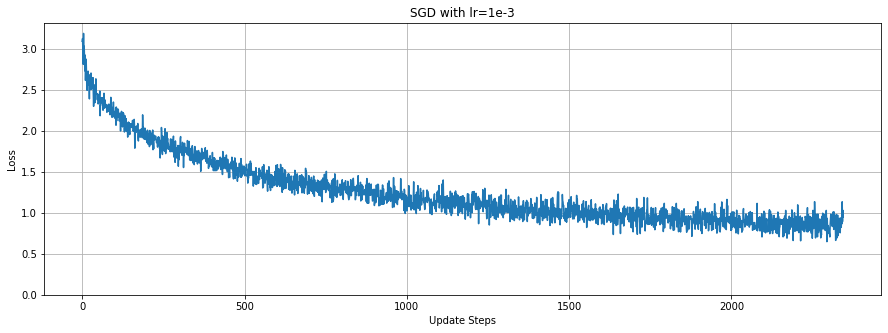

In [24]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

In [ ]:
"""
We can't really tell how "good" it is without comparing it against another optimizer.
"""

# Optimizer #2: SGD with Momentum

In [ ]:
"""
One way to think of SGD is a ball rolling down a hill, where areas of high gradient are steep parts of the hill and
areas of low gradient are very flat areas. Sometimes the global minima, the point with the lowest loss, is in the 
middle of a giant flat area. The problem is that because these flat areas have small gradients they also give small
update steps which makes learning slow.

What if we expanded on the "ball rolling down a hill" analogy? We'd want to add something to our optimizer that made
it keep the "momentum" gained rolling down the steep hills whilst it's going across the flat areas.
"""

In [25]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

In [26]:
optimizer = SGDMomentum(model.parameters())

In [27]:
sgd_momentum_loss = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:25, 18.35it/s]



  1%|          | 5/469 [00:00<00:21, 21.22it/s]



  2%|▏         | 8/469 [00:00<00:20, 22.58it/s]



  2%|▏         | 11/469 [00:00<00:20, 22.89it/s]



  3%|▎         | 14/469 [00:00<00:20, 22.14it/s]



  4%|▎         | 17/469 [00:00<00:20, 22.30it/s]



  4%|▍         | 20/469 [00:00<00:19, 22.66it/s]



  5%|▍         | 23/469 [00:01<00:19, 22.84it/s]



  6%|▌         | 26/469 [00:01<00:19, 22.68it/s]



  6%|▌         | 29/469 [00:01<00:19, 22.06it/s]



  7%|▋         | 32/469 [00:01<00:20, 21.69it/s]



  7%|▋         | 35/469 [00:01<00:20, 21.22it/s]



  8%|▊         | 38/469 [00:01<00:20, 20.93it/s]



  9%|▊         | 41/469 [00:01<00:20, 20.91it/s]



  9%|▉         | 44/469 [00:02<00:20, 20.89it/s]



 10%|█         | 47/469 [00:02<00:20, 20.92it/s]



 11%|█         | 50/469 [00:02<00:19, 21.51it/s]



 11%|█▏        | 53/469 [00:02<00:18, 21.98it/s]



 12%|█▏        | 56/

 59%|█████▉    | 278/469 [00:12<00:08, 21.61it/s]



 60%|█████▉    | 281/469 [00:12<00:08, 21.48it/s]



 61%|██████    | 284/469 [00:12<00:08, 21.44it/s]



 61%|██████    | 287/469 [00:13<00:08, 21.33it/s]



 62%|██████▏   | 290/469 [00:13<00:08, 21.34it/s]



 62%|██████▏   | 293/469 [00:13<00:08, 21.41it/s]



 63%|██████▎   | 296/469 [00:13<00:08, 21.46it/s]



 64%|██████▍   | 299/469 [00:13<00:07, 21.48it/s]



 64%|██████▍   | 302/469 [00:13<00:07, 21.34it/s]



 65%|██████▌   | 305/469 [00:13<00:07, 21.45it/s]



 66%|██████▌   | 308/469 [00:14<00:07, 21.35it/s]



 66%|██████▋   | 311/469 [00:14<00:07, 21.44it/s]



 67%|██████▋   | 314/469 [00:14<00:07, 21.51it/s]



 68%|██████▊   | 317/469 [00:14<00:07, 21.53it/s]



 68%|██████▊   | 320/469 [00:14<00:06, 21.61it/s]



 69%|██████▉   | 323/469 [00:14<00:06, 21.56it/s]



 70%|██████▉   | 326/469 [00:14<00:06, 21.57it/s]



 70%|███████   | 329/469 [00:15<00:06, 21.49it/s]



 71%|███████   | 332/469 [00:15<00:06, 21.42it

 19%|█▉        | 90/469 [00:04<00:18, 20.52it/s]



 20%|█▉        | 93/469 [00:04<00:17, 21.26it/s]



 20%|██        | 96/469 [00:04<00:17, 20.89it/s]



 21%|██        | 99/469 [00:04<00:17, 20.63it/s]



 22%|██▏       | 102/469 [00:04<00:17, 20.78it/s]



 22%|██▏       | 105/469 [00:04<00:17, 20.80it/s]



 23%|██▎       | 108/469 [00:04<00:17, 20.72it/s]



 24%|██▎       | 111/469 [00:05<00:16, 21.15it/s]



 24%|██▍       | 114/469 [00:05<00:16, 21.53it/s]



 25%|██▍       | 117/469 [00:05<00:16, 21.21it/s]



 26%|██▌       | 120/469 [00:05<00:16, 21.51it/s]



 26%|██▌       | 123/469 [00:05<00:16, 21.37it/s]



 27%|██▋       | 126/469 [00:05<00:15, 21.80it/s]



 28%|██▊       | 129/469 [00:05<00:15, 21.76it/s]



 28%|██▊       | 132/469 [00:06<00:15, 22.35it/s]



 29%|██▉       | 135/469 [00:06<00:14, 22.62it/s]



 29%|██▉       | 138/469 [00:06<00:14, 22.25it/s]



 30%|███       | 141/469 [00:06<00:15, 21.86it/s]



 31%|███       | 144/469 [00:06<00:15, 21.63it/s]


 69%|██████▉   | 324/469 [00:14<00:06, 21.48it/s]



 70%|██████▉   | 327/469 [00:14<00:06, 21.25it/s]



 70%|███████   | 330/469 [00:14<00:06, 20.50it/s]



 71%|███████   | 333/469 [00:14<00:06, 20.52it/s]



 72%|███████▏  | 336/469 [00:15<00:06, 21.16it/s]



 72%|███████▏  | 339/469 [00:15<00:05, 21.99it/s]



 73%|███████▎  | 342/469 [00:15<00:05, 22.20it/s]



 74%|███████▎  | 345/469 [00:15<00:05, 22.20it/s]



 74%|███████▍  | 348/469 [00:15<00:05, 22.45it/s]



 75%|███████▍  | 351/469 [00:15<00:05, 22.28it/s]



 75%|███████▌  | 354/469 [00:15<00:05, 21.62it/s]



 76%|███████▌  | 357/469 [00:15<00:05, 22.13it/s]



 77%|███████▋  | 360/469 [00:16<00:04, 22.39it/s]



 77%|███████▋  | 363/469 [00:16<00:04, 22.96it/s]



 78%|███████▊  | 366/469 [00:16<00:04, 23.52it/s]



 79%|███████▊  | 369/469 [00:16<00:04, 23.77it/s]



 79%|███████▉  | 372/469 [00:16<00:04, 23.92it/s]



 80%|███████▉  | 375/469 [00:16<00:03, 23.83it/s]



 81%|████████  | 378/469 [00:16<00:03, 23.18it

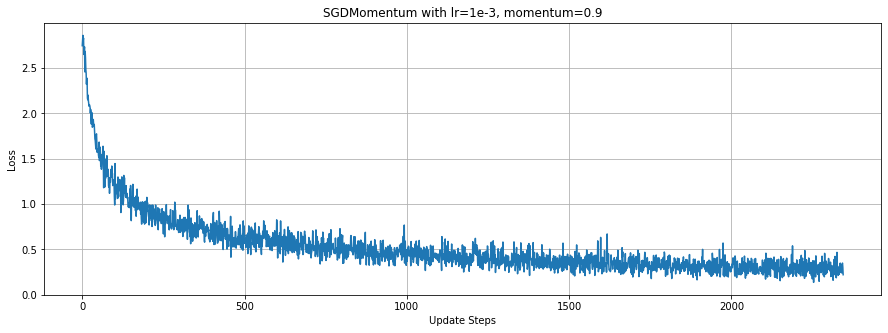

In [28]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3, momentum=0.9')

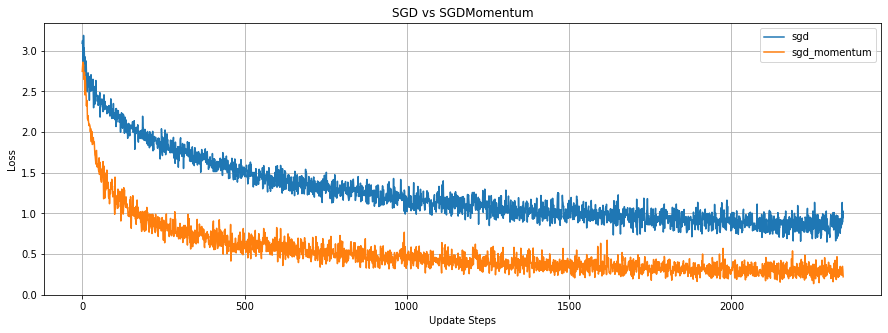

In [29]:
losses = [sgd_loss, sgd_momentum_loss]
labels = ['sgd', 'sgd_momentum']

plot_losses(losses, labels, 'SGD vs SGDMomentum')

# Optimizer #3: Adagrad

In [ ]:
"""
One downside with SGD is that we use a single learning rate across all of our parameters, and that this learning
rate is fixed through the entirety of training. Ideally, parameters that are updated more frequently have a lower 
learning rate and parameters that are updated infrequently have a larger learning rate. This is what Adagrd is for.
"""

In [30]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [31]:
optimizer = Adagrad(model.parameters())

In [32]:
adagrad_loss = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:27, 17.10it/s]



  1%|          | 5/469 [00:00<00:23, 20.13it/s]



  1%|▏         | 7/469 [00:00<00:23, 19.81it/s]



  2%|▏         | 10/469 [00:00<00:21, 21.07it/s]



  3%|▎         | 13/469 [00:00<00:21, 20.95it/s]



  3%|▎         | 16/469 [00:00<00:21, 20.91it/s]



  4%|▍         | 19/469 [00:00<00:21, 20.69it/s]



  5%|▍         | 22/469 [00:01<00:21, 20.99it/s]



  5%|▌         | 25/469 [00:01<00:21, 20.67it/s]



  6%|▌         | 28/469 [00:01<00:21, 20.59it/s]



  7%|▋         | 31/469 [00:01<00:21, 20.72it/s]



  7%|▋         | 34/469 [00:01<00:20, 20.78it/s]



  8%|▊         | 37/469 [00:01<00:20, 20.81it/s]



  9%|▊         | 40/469 [00:01<00:20, 21.32it/s]



  9%|▉         | 43/469 [00:02<00:19, 21.81it/s]



 10%|▉         | 46/469 [00:02<00:19, 21.96it/s]



 10%|█         | 49/469 [00:02<00:19, 21.46it/s]



 11%|█         | 52/469 [00:02<00:19, 21.28it/s]



 12%|█▏        | 55/

 60%|██████    | 282/469 [00:11<00:07, 23.88it/s]



 61%|██████    | 285/469 [00:12<00:07, 23.97it/s]



 61%|██████▏   | 288/469 [00:12<00:07, 24.21it/s]



 62%|██████▏   | 291/469 [00:12<00:07, 24.13it/s]



 63%|██████▎   | 294/469 [00:12<00:07, 23.59it/s]



 63%|██████▎   | 297/469 [00:12<00:07, 23.18it/s]



 64%|██████▍   | 300/469 [00:12<00:07, 23.09it/s]



 65%|██████▍   | 303/469 [00:12<00:07, 23.49it/s]



 65%|██████▌   | 306/469 [00:12<00:06, 23.89it/s]



 66%|██████▌   | 309/469 [00:13<00:06, 24.15it/s]



 67%|██████▋   | 312/469 [00:13<00:06, 24.26it/s]



 67%|██████▋   | 315/469 [00:13<00:06, 24.25it/s]



 68%|██████▊   | 318/469 [00:13<00:06, 23.84it/s]



 68%|██████▊   | 321/469 [00:13<00:06, 23.90it/s]



 69%|██████▉   | 324/469 [00:13<00:06, 23.24it/s]



 70%|██████▉   | 327/469 [00:13<00:06, 23.40it/s]



 70%|███████   | 330/469 [00:13<00:05, 23.65it/s]



 71%|███████   | 333/469 [00:14<00:05, 23.81it/s]



 72%|███████▏  | 336/469 [00:14<00:05, 23.94it

 20%|██        | 96/469 [00:04<00:15, 23.33it/s]



 21%|██        | 99/469 [00:04<00:15, 23.26it/s]



 22%|██▏       | 102/469 [00:04<00:15, 23.31it/s]



 22%|██▏       | 105/469 [00:04<00:15, 23.53it/s]



 23%|██▎       | 108/469 [00:04<00:15, 23.80it/s]



 24%|██▎       | 111/469 [00:04<00:15, 23.83it/s]



 24%|██▍       | 114/469 [00:04<00:15, 23.41it/s]



 25%|██▍       | 117/469 [00:05<00:15, 23.24it/s]



 26%|██▌       | 120/469 [00:05<00:14, 23.60it/s]



 26%|██▌       | 123/469 [00:05<00:14, 23.25it/s]



 27%|██▋       | 126/469 [00:05<00:14, 22.95it/s]



 28%|██▊       | 129/469 [00:05<00:14, 23.12it/s]



 28%|██▊       | 132/469 [00:05<00:14, 23.44it/s]



 29%|██▉       | 135/469 [00:05<00:14, 23.66it/s]



 29%|██▉       | 138/469 [00:06<00:14, 23.63it/s]



 30%|███       | 141/469 [00:06<00:14, 23.10it/s]



 31%|███       | 144/469 [00:06<00:13, 23.27it/s]



 31%|███▏      | 147/469 [00:06<00:13, 23.14it/s]



 32%|███▏      | 150/469 [00:06<00:13, 23.06it/s

 81%|████████  | 380/469 [00:17<00:04, 17.84it/s]



 81%|████████▏ | 382/469 [00:17<00:04, 17.41it/s]



 82%|████████▏ | 384/469 [00:17<00:05, 16.93it/s]



 82%|████████▏ | 386/469 [00:17<00:04, 17.02it/s]



 83%|████████▎ | 388/469 [00:17<00:04, 17.35it/s]



 83%|████████▎ | 390/469 [00:17<00:04, 17.30it/s]



 84%|████████▎ | 392/469 [00:17<00:04, 17.92it/s]



 84%|████████▍ | 395/469 [00:17<00:03, 18.81it/s]



 85%|████████▍ | 397/469 [00:17<00:03, 18.89it/s]



 85%|████████▌ | 400/469 [00:18<00:03, 19.49it/s]



 86%|████████▌ | 402/469 [00:18<00:03, 19.26it/s]



 86%|████████▌ | 404/469 [00:18<00:03, 18.76it/s]



 87%|████████▋ | 406/469 [00:18<00:03, 18.79it/s]



 87%|████████▋ | 408/469 [00:18<00:03, 18.81it/s]



 87%|████████▋ | 410/469 [00:18<00:03, 18.99it/s]



 88%|████████▊ | 412/469 [00:18<00:03, 18.74it/s]



 88%|████████▊ | 414/469 [00:18<00:02, 18.69it/s]



 89%|████████▊ | 416/469 [00:18<00:02, 18.43it/s]



 89%|████████▉ | 418/469 [00:19<00:02, 18.16it

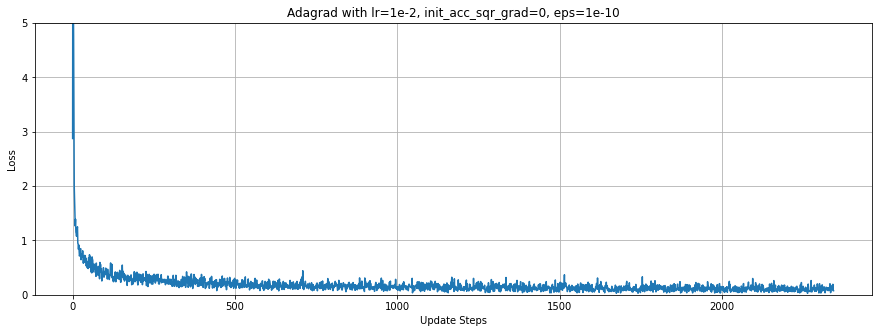

In [33]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10', ymax=5.0)

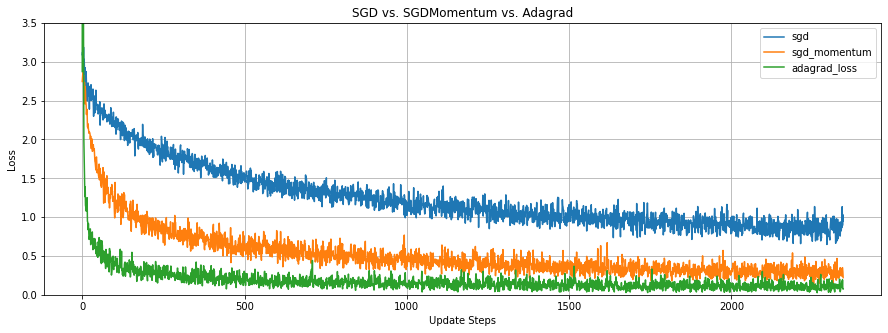

In [37]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd_momentum', 'adagrad_loss']
plot_losses(losses, labels, 'SGD vs. SGDMomentum vs. Adagrad', ymax= 3.5)

In [ ]:
"""
We can see there's an initial large spike in the loss value of adagrad. This is due to the initial $G$ values being very 
small and thus the learning rate is divided by a very small number making it very large. Very large learning rates
usually lead to unstable training which give higher loss values.

Can we do something about it? Adagrad beats the other two pretty handily, but that initial spike in loss doesn't 
look very nice. Maybe if we get rid of that initial spike we can make Adagrad perform even better? Let's try some 
different initial values for $G$ and store them all in a adagrad_losses dictionary. Each key in the dictionary will
be the initial $G$ value and the values of the dictionary will be a list of training loss per batch.
"""

In [38]:
adagrad_losses = {0: adagrad_loss}

In [39]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=1.0)

In [40]:
adagrad_losses[1.0] = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:24, 18.77it/s]



  1%|          | 4/469 [00:00<00:24, 19.13it/s]



  1%|▏         | 7/469 [00:00<00:22, 20.67it/s]



  2%|▏         | 10/469 [00:00<00:21, 21.08it/s]



  3%|▎         | 13/469 [00:00<00:21, 21.22it/s]



  3%|▎         | 16/469 [00:00<00:20, 21.91it/s]



  4%|▍         | 19/469 [00:00<00:20, 22.42it/s]



  5%|▍         | 22/469 [00:01<00:19, 22.77it/s]



  5%|▌         | 25/469 [00:01<00:19, 22.84it/s]



  6%|▌         | 28/469 [00:01<00:19, 22.68it/s]



  7%|▋         | 31/469 [00:01<00:19, 22.94it/s]



  7%|▋         | 34/469 [00:01<00:19, 22.71it/s]



  8%|▊         | 37/469 [00:01<00:19, 22.71it/s]



  9%|▊         | 40/469 [00:01<00:18, 22.85it/s]



  9%|▉         | 43/469 [00:01<00:18, 22.85it/s]



 10%|▉         | 46/469 [00:02<00:18, 23.19it/s]



 10%|█         | 49/469 [00:02<00:17, 23.47it/s]



 11%|█         | 52/469 [00:02<00:17, 23.38it/s]



 12%|█▏        | 55/

 59%|█████▉    | 279/469 [00:12<00:09, 19.98it/s]



 60%|██████    | 282/469 [00:12<00:09, 20.63it/s]



 61%|██████    | 285/469 [00:12<00:08, 21.49it/s]



 61%|██████▏   | 288/469 [00:12<00:08, 22.17it/s]



 62%|██████▏   | 291/469 [00:12<00:07, 22.41it/s]



 63%|██████▎   | 294/469 [00:12<00:07, 22.95it/s]



 63%|██████▎   | 297/469 [00:12<00:07, 22.57it/s]



 64%|██████▍   | 300/469 [00:13<00:07, 22.26it/s]



 65%|██████▍   | 303/469 [00:13<00:07, 21.67it/s]



 65%|██████▌   | 306/469 [00:13<00:07, 21.51it/s]



 66%|██████▌   | 309/469 [00:13<00:07, 21.39it/s]



 67%|██████▋   | 312/469 [00:13<00:07, 21.02it/s]



 67%|██████▋   | 315/469 [00:13<00:07, 20.97it/s]



 68%|██████▊   | 318/469 [00:13<00:07, 21.08it/s]



 68%|██████▊   | 321/469 [00:14<00:07, 21.13it/s]



 69%|██████▉   | 324/469 [00:14<00:06, 21.77it/s]



 70%|██████▉   | 327/469 [00:14<00:06, 21.62it/s]



 70%|███████   | 330/469 [00:14<00:06, 21.63it/s]



 71%|███████   | 333/469 [00:14<00:06, 22.09it

 20%|█▉        | 93/469 [00:03<00:15, 24.17it/s]



 20%|██        | 96/469 [00:03<00:15, 24.45it/s]



 21%|██        | 99/469 [00:04<00:15, 24.39it/s]



 22%|██▏       | 102/469 [00:04<00:14, 24.55it/s]



 22%|██▏       | 105/469 [00:04<00:14, 24.47it/s]



 23%|██▎       | 108/469 [00:04<00:14, 24.14it/s]



 24%|██▎       | 111/469 [00:04<00:14, 24.33it/s]



 24%|██▍       | 114/469 [00:04<00:14, 23.77it/s]



 25%|██▍       | 117/469 [00:04<00:14, 23.95it/s]



 26%|██▌       | 120/469 [00:04<00:14, 24.16it/s]



 26%|██▌       | 123/469 [00:05<00:14, 24.06it/s]



 27%|██▋       | 126/469 [00:05<00:14, 24.25it/s]



 28%|██▊       | 129/469 [00:05<00:13, 24.31it/s]



 28%|██▊       | 132/469 [00:05<00:13, 24.16it/s]



 29%|██▉       | 135/469 [00:05<00:13, 24.36it/s]



 29%|██▉       | 138/469 [00:05<00:13, 23.84it/s]



 30%|███       | 141/469 [00:05<00:14, 23.41it/s]



 31%|███       | 144/469 [00:05<00:13, 23.76it/s]



 31%|███▏      | 147/469 [00:06<00:13, 24.10it/s]

 81%|████████  | 378/469 [00:15<00:03, 24.19it/s]



 81%|████████  | 381/469 [00:15<00:03, 24.34it/s]



 82%|████████▏ | 384/469 [00:15<00:03, 24.54it/s]



 83%|████████▎ | 387/469 [00:16<00:03, 24.64it/s]



 83%|████████▎ | 390/469 [00:16<00:03, 24.26it/s]



 84%|████████▍ | 393/469 [00:16<00:03, 24.34it/s]



 84%|████████▍ | 396/469 [00:16<00:02, 24.35it/s]



 85%|████████▌ | 399/469 [00:16<00:02, 23.79it/s]



 86%|████████▌ | 402/469 [00:16<00:02, 24.20it/s]



 86%|████████▋ | 405/469 [00:16<00:02, 24.33it/s]



 87%|████████▋ | 408/469 [00:16<00:02, 24.56it/s]



 88%|████████▊ | 411/469 [00:17<00:02, 24.45it/s]



 88%|████████▊ | 414/469 [00:17<00:02, 24.18it/s]



 89%|████████▉ | 417/469 [00:17<00:02, 24.39it/s]



 90%|████████▉ | 420/469 [00:17<00:02, 24.42it/s]



 90%|█████████ | 423/469 [00:17<00:01, 24.09it/s]



 91%|█████████ | 426/469 [00:17<00:01, 23.87it/s]



 91%|█████████▏| 429/469 [00:17<00:01, 23.96it/s]



 92%|█████████▏| 432/469 [00:17<00:01, 24.32it

In [41]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.1)

In [42]:
adagrad_losses[0.1] = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:25, 18.27it/s]



  1%|          | 5/469 [00:00<00:22, 21.05it/s]



  2%|▏         | 8/469 [00:00<00:21, 21.62it/s]



  2%|▏         | 11/469 [00:00<00:21, 21.54it/s]



  3%|▎         | 14/469 [00:00<00:21, 21.29it/s]



  4%|▎         | 17/469 [00:00<00:20, 21.83it/s]



  4%|▍         | 20/469 [00:00<00:20, 21.72it/s]



  5%|▍         | 23/469 [00:01<00:20, 21.47it/s]



  6%|▌         | 26/469 [00:01<00:21, 21.01it/s]



  6%|▌         | 29/469 [00:01<00:21, 20.79it/s]



  7%|▋         | 32/469 [00:01<00:20, 21.41it/s]



  7%|▋         | 35/469 [00:01<00:20, 21.03it/s]



  8%|▊         | 38/469 [00:01<00:20, 21.11it/s]



  9%|▊         | 41/469 [00:01<00:19, 21.95it/s]



  9%|▉         | 44/469 [00:02<00:18, 22.64it/s]



 10%|█         | 47/469 [00:02<00:18, 22.33it/s]



 11%|█         | 50/469 [00:02<00:19, 21.74it/s]



 11%|█▏        | 53/469 [00:02<00:19, 21.62it/s]



 12%|█▏        | 56/

 60%|█████▉    | 280/469 [00:12<00:08, 23.06it/s]



 60%|██████    | 283/469 [00:12<00:08, 22.22it/s]



 61%|██████    | 286/469 [00:12<00:08, 22.31it/s]



 62%|██████▏   | 289/469 [00:12<00:07, 22.66it/s]



 62%|██████▏   | 292/469 [00:13<00:07, 22.24it/s]



 63%|██████▎   | 295/469 [00:13<00:07, 22.15it/s]



 64%|██████▎   | 298/469 [00:13<00:07, 22.06it/s]



 64%|██████▍   | 301/469 [00:13<00:07, 22.46it/s]



 65%|██████▍   | 304/469 [00:13<00:07, 23.05it/s]



 65%|██████▌   | 307/469 [00:13<00:07, 22.89it/s]



 66%|██████▌   | 310/469 [00:13<00:06, 23.36it/s]



 67%|██████▋   | 313/469 [00:14<00:06, 23.42it/s]



 67%|██████▋   | 316/469 [00:14<00:06, 23.69it/s]



 68%|██████▊   | 319/469 [00:14<00:06, 23.40it/s]



 69%|██████▊   | 322/469 [00:14<00:06, 23.73it/s]



 69%|██████▉   | 325/469 [00:14<00:06, 23.80it/s]



 70%|██████▉   | 328/469 [00:14<00:05, 23.97it/s]



 71%|███████   | 331/469 [00:14<00:05, 23.27it/s]



 71%|███████   | 334/469 [00:14<00:05, 23.20it

 20%|█▉        | 93/469 [00:03<00:16, 23.19it/s]



 20%|██        | 96/469 [00:04<00:15, 23.40it/s]



 21%|██        | 99/469 [00:04<00:15, 23.27it/s]



 22%|██▏       | 102/469 [00:04<00:15, 23.17it/s]



 22%|██▏       | 105/469 [00:04<00:15, 23.42it/s]



 23%|██▎       | 108/469 [00:04<00:15, 23.54it/s]



 24%|██▎       | 111/469 [00:04<00:15, 23.84it/s]



 24%|██▍       | 114/469 [00:04<00:15, 22.90it/s]



 25%|██▍       | 117/469 [00:04<00:16, 21.02it/s]



 26%|██▌       | 120/469 [00:05<00:16, 21.73it/s]



 26%|██▌       | 123/469 [00:05<00:15, 22.37it/s]



 27%|██▋       | 126/469 [00:05<00:14, 22.96it/s]



 28%|██▊       | 129/469 [00:05<00:14, 23.57it/s]



 28%|██▊       | 132/469 [00:05<00:14, 23.45it/s]



 29%|██▉       | 135/469 [00:05<00:14, 23.29it/s]



 29%|██▉       | 138/469 [00:05<00:14, 22.99it/s]



 30%|███       | 141/469 [00:06<00:14, 23.24it/s]



 31%|███       | 144/469 [00:06<00:13, 23.60it/s]



 31%|███▏      | 147/469 [00:06<00:13, 23.25it/s]

 81%|████████  | 378/469 [00:15<00:04, 21.73it/s]



 81%|████████  | 381/469 [00:15<00:04, 21.62it/s]



 82%|████████▏ | 384/469 [00:16<00:03, 21.75it/s]



 83%|████████▎ | 387/469 [00:16<00:03, 21.69it/s]



 83%|████████▎ | 390/469 [00:16<00:03, 20.86it/s]



 84%|████████▍ | 393/469 [00:16<00:03, 20.42it/s]



 84%|████████▍ | 396/469 [00:16<00:03, 20.45it/s]



 85%|████████▌ | 399/469 [00:16<00:03, 21.23it/s]



 86%|████████▌ | 402/469 [00:16<00:03, 22.21it/s]



 86%|████████▋ | 405/469 [00:17<00:02, 21.63it/s]



 87%|████████▋ | 408/469 [00:17<00:02, 21.71it/s]



 88%|████████▊ | 411/469 [00:17<00:02, 22.12it/s]



 88%|████████▊ | 414/469 [00:17<00:02, 21.86it/s]



 89%|████████▉ | 417/469 [00:17<00:02, 21.93it/s]



 90%|████████▉ | 420/469 [00:17<00:02, 21.93it/s]



 90%|█████████ | 423/469 [00:17<00:02, 22.36it/s]



 91%|█████████ | 426/469 [00:18<00:01, 22.79it/s]



 91%|█████████▏| 429/469 [00:18<00:01, 22.24it/s]



 92%|█████████▏| 432/469 [00:18<00:01, 22.11it

In [43]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.01)
adagrad_losses[0.01] = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:25, 18.67it/s]



  1%|          | 5/469 [00:00<00:21, 21.61it/s]



  2%|▏         | 8/469 [00:00<00:20, 22.65it/s]



  2%|▏         | 11/469 [00:00<00:19, 22.95it/s]



  3%|▎         | 14/469 [00:00<00:19, 23.24it/s]



  4%|▎         | 17/469 [00:00<00:19, 22.89it/s]



  4%|▍         | 20/469 [00:00<00:19, 22.78it/s]



  5%|▍         | 23/469 [00:01<00:20, 22.07it/s]



  6%|▌         | 26/469 [00:01<00:20, 21.72it/s]



  6%|▌         | 29/469 [00:01<00:20, 21.61it/s]



  7%|▋         | 32/469 [00:01<00:20, 21.79it/s]



  7%|▋         | 35/469 [00:01<00:20, 21.39it/s]



  8%|▊         | 38/469 [00:01<00:20, 21.09it/s]



  9%|▊         | 41/469 [00:01<00:20, 20.87it/s]



  9%|▉         | 44/469 [00:02<00:19, 21.41it/s]



 10%|█         | 47/469 [00:02<00:19, 21.51it/s]



 11%|█         | 50/469 [00:02<00:19, 21.54it/s]



 11%|█▏        | 53/469 [00:02<00:19, 21.78it/s]



 12%|█▏        | 56/

 61%|██████    | 285/469 [00:12<00:07, 23.94it/s]



 61%|██████▏   | 288/469 [00:12<00:07, 24.26it/s]



 62%|██████▏   | 291/469 [00:12<00:07, 24.24it/s]



 63%|██████▎   | 294/469 [00:12<00:07, 24.40it/s]



 63%|██████▎   | 297/469 [00:12<00:07, 24.41it/s]



 64%|██████▍   | 300/469 [00:12<00:06, 24.61it/s]



 65%|██████▍   | 303/469 [00:12<00:06, 24.39it/s]



 65%|██████▌   | 306/469 [00:12<00:07, 23.00it/s]



 66%|██████▌   | 309/469 [00:13<00:07, 22.23it/s]



 67%|██████▋   | 312/469 [00:13<00:07, 21.73it/s]



 67%|██████▋   | 315/469 [00:13<00:07, 21.58it/s]



 68%|██████▊   | 318/469 [00:13<00:06, 22.04it/s]



 68%|██████▊   | 321/469 [00:13<00:06, 22.81it/s]



 69%|██████▉   | 324/469 [00:13<00:06, 23.40it/s]



 70%|██████▉   | 327/469 [00:13<00:06, 23.51it/s]



 70%|███████   | 330/469 [00:13<00:05, 23.58it/s]



 71%|███████   | 333/469 [00:14<00:05, 22.85it/s]



 72%|███████▏  | 336/469 [00:14<00:05, 23.05it/s]



 72%|███████▏  | 339/469 [00:14<00:05, 23.60it

 19%|█▊        | 87/469 [00:03<00:16, 23.77it/s]



 19%|█▉        | 90/469 [00:03<00:15, 24.03it/s]



 20%|█▉        | 93/469 [00:03<00:15, 24.40it/s]



 20%|██        | 96/469 [00:04<00:15, 24.42it/s]



 21%|██        | 99/469 [00:04<00:15, 24.62it/s]



 22%|██▏       | 102/469 [00:04<00:15, 24.32it/s]



 22%|██▏       | 105/469 [00:04<00:15, 24.16it/s]



 23%|██▎       | 108/469 [00:04<00:14, 24.35it/s]



 24%|██▎       | 111/469 [00:04<00:15, 23.78it/s]



 24%|██▍       | 114/469 [00:04<00:14, 24.06it/s]



 25%|██▍       | 117/469 [00:04<00:14, 24.32it/s]



 26%|██▌       | 120/469 [00:04<00:14, 24.31it/s]



 26%|██▌       | 123/469 [00:05<00:14, 23.94it/s]



 27%|██▋       | 126/469 [00:05<00:14, 23.86it/s]



 28%|██▊       | 129/469 [00:05<00:14, 24.18it/s]



 28%|██▊       | 132/469 [00:05<00:13, 24.42it/s]



 29%|██▉       | 135/469 [00:05<00:13, 24.37it/s]



 29%|██▉       | 138/469 [00:05<00:14, 23.46it/s]



 30%|███       | 141/469 [00:05<00:13, 23.57it/s]



 79%|███████▉  | 372/469 [00:16<00:04, 22.53it/s]



 80%|███████▉  | 375/469 [00:16<00:04, 22.56it/s]



 81%|████████  | 378/469 [00:16<00:04, 22.41it/s]



 81%|████████  | 381/469 [00:16<00:03, 22.06it/s]



 82%|████████▏ | 384/469 [00:16<00:03, 22.13it/s]



 83%|████████▎ | 387/469 [00:16<00:03, 22.41it/s]



 83%|████████▎ | 390/469 [00:16<00:03, 22.56it/s]



 84%|████████▍ | 393/469 [00:16<00:03, 23.23it/s]



 84%|████████▍ | 396/469 [00:17<00:03, 23.49it/s]



 85%|████████▌ | 399/469 [00:17<00:02, 23.87it/s]



 86%|████████▌ | 402/469 [00:17<00:03, 22.21it/s]



 86%|████████▋ | 405/469 [00:17<00:02, 21.67it/s]



 87%|████████▋ | 408/469 [00:17<00:02, 21.84it/s]



 88%|████████▊ | 411/469 [00:17<00:02, 21.93it/s]



 88%|████████▊ | 414/469 [00:17<00:02, 21.74it/s]



 89%|████████▉ | 417/469 [00:18<00:02, 22.27it/s]



 90%|████████▉ | 420/469 [00:18<00:02, 22.74it/s]



 90%|█████████ | 423/469 [00:18<00:02, 21.92it/s]



 91%|█████████ | 426/469 [00:18<00:02, 21.35it

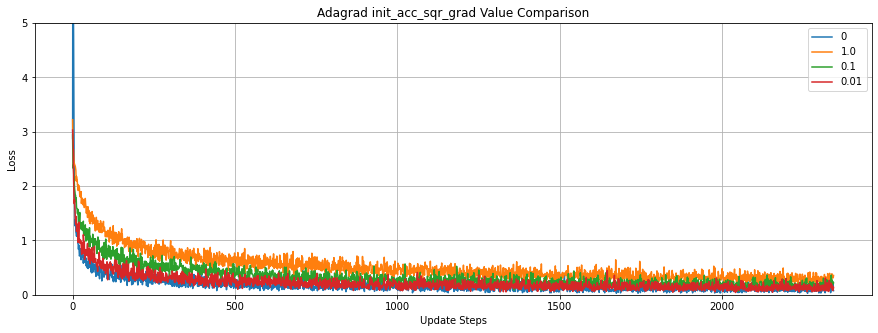

In [44]:
labels, losses = zip(*adagrad_losses.items())
plot_losses(losses, labels, 'Adagrad init_acc_sqr_grad Value Comparison', ymax=5.0)

In [ ]:
"""
As we can see, performance of Adagrad increases as the initial $G$ value decreases, but decreasing $G$ also 
increases the initial spike in loss at the beginning of training.

Why does the performance decrease as the initial $G$ value increases? This is the major downside of Adagrad: 
as $G$ is monotonically increasing at each time-step it will be dividing the learning rate by a monotonically
increasing number at each time-step. This causes the size of the steps taken to reduce every update step. As 
the results for an initial $G$ value of 1.0 show, we can see that these smaller step sizes actually increase 
the time taken for the model to converge, and in extreme cases will cause the step sizes to approach zero meaning
the parameters will stop updating completely.

In practice, we do want the learning rate to decrease whilst training, but ideally would not want it to become zero.
"""

# Optimizer #4: Adadelta

In [ ]:
"""
The problem of the Adagrad algorithm was that G was monotonically increasing. Auto delta solves this problem 
by replacing G with an exponential moving average of the square of the gradients
"""

In [48]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params] 

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [49]:
optimizer = Adadelta(model.parameters())
adadelta_loss = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:30, 15.35it/s]



  1%|          | 4/469 [00:00<00:27, 17.18it/s]



  1%|▏         | 6/469 [00:00<00:25, 18.36it/s]



  2%|▏         | 8/469 [00:00<00:24, 18.84it/s]



  2%|▏         | 11/469 [00:00<00:22, 20.21it/s]



  3%|▎         | 14/469 [00:00<00:22, 20.52it/s]



  4%|▎         | 17/469 [00:00<00:22, 20.44it/s]



  4%|▍         | 20/469 [00:01<00:21, 20.48it/s]



  5%|▍         | 23/469 [00:01<00:21, 20.37it/s]



  6%|▌         | 26/469 [00:01<00:21, 20.45it/s]



  6%|▌         | 29/469 [00:01<00:21, 20.82it/s]



  7%|▋         | 32/469 [00:01<00:21, 20.30it/s]



  7%|▋         | 35/469 [00:01<00:20, 20.95it/s]



  8%|▊         | 38/469 [00:01<00:20, 20.76it/s]



  9%|▊         | 41/469 [00:02<00:20, 20.93it/s]



  9%|▉         | 44/469 [00:02<00:20, 20.63it/s]



 10%|█         | 47/469 [00:02<00:20, 20.93it/s]



 11%|█         | 50/469 [00:02<00:20, 20.86it/s]



 11%|█▏        | 53/4

 56%|█████▌    | 261/469 [00:11<00:09, 21.92it/s]



 56%|█████▋    | 264/469 [00:11<00:09, 21.80it/s]



 57%|█████▋    | 267/469 [00:11<00:09, 21.58it/s]



 58%|█████▊    | 270/469 [00:12<00:09, 21.25it/s]



 58%|█████▊    | 273/469 [00:12<00:09, 20.84it/s]



 59%|█████▉    | 276/469 [00:12<00:09, 20.83it/s]



 59%|█████▉    | 279/469 [00:12<00:09, 20.87it/s]



 60%|██████    | 282/469 [00:12<00:08, 20.91it/s]



 61%|██████    | 285/469 [00:12<00:08, 21.52it/s]



 61%|██████▏   | 288/469 [00:12<00:08, 21.95it/s]



 62%|██████▏   | 291/469 [00:13<00:08, 21.98it/s]



 63%|██████▎   | 294/469 [00:13<00:07, 21.94it/s]



 63%|██████▎   | 297/469 [00:13<00:08, 20.32it/s]



 64%|██████▍   | 300/469 [00:13<00:08, 20.33it/s]



 65%|██████▍   | 303/469 [00:13<00:07, 21.00it/s]



 65%|██████▌   | 306/469 [00:13<00:07, 21.56it/s]



 66%|██████▌   | 309/469 [00:13<00:07, 22.07it/s]



 67%|██████▋   | 312/469 [00:13<00:07, 22.32it/s]



 67%|██████▋   | 315/469 [00:14<00:07, 21.99it

 12%|█▏        | 57/469 [00:02<00:18, 22.37it/s]



 13%|█▎        | 60/469 [00:02<00:18, 22.52it/s]



 13%|█▎        | 63/469 [00:02<00:17, 22.69it/s]



 14%|█▍        | 66/469 [00:02<00:18, 22.26it/s]



 15%|█▍        | 69/469 [00:03<00:17, 22.45it/s]



 15%|█▌        | 72/469 [00:03<00:17, 22.66it/s]



 16%|█▌        | 75/469 [00:03<00:17, 22.34it/s]



 17%|█▋        | 78/469 [00:03<00:17, 22.45it/s]



 17%|█▋        | 81/469 [00:03<00:17, 22.66it/s]



 18%|█▊        | 84/469 [00:03<00:16, 22.79it/s]



 19%|█▊        | 87/469 [00:03<00:16, 22.74it/s]



 19%|█▉        | 90/469 [00:04<00:17, 21.90it/s]



 20%|█▉        | 93/469 [00:04<00:17, 22.07it/s]



 20%|██        | 96/469 [00:04<00:16, 22.16it/s]



 21%|██        | 99/469 [00:04<00:16, 22.39it/s]



 22%|██▏       | 102/469 [00:04<00:16, 22.22it/s]



 22%|██▏       | 105/469 [00:04<00:16, 22.39it/s]



 23%|██▎       | 108/469 [00:04<00:15, 22.60it/s]



 24%|██▎       | 111/469 [00:04<00:15, 22.52it/s]



 24%|██▍

 73%|███████▎  | 342/469 [00:15<00:05, 22.28it/s]



 74%|███████▎  | 345/469 [00:15<00:05, 22.50it/s]



 74%|███████▍  | 348/469 [00:15<00:05, 22.54it/s]



 75%|███████▍  | 351/469 [00:15<00:05, 22.40it/s]



 75%|███████▌  | 354/469 [00:15<00:05, 22.53it/s]



 76%|███████▌  | 357/469 [00:15<00:04, 22.61it/s]



 77%|███████▋  | 360/469 [00:16<00:04, 21.93it/s]



 77%|███████▋  | 363/469 [00:16<00:04, 22.03it/s]



 78%|███████▊  | 366/469 [00:16<00:04, 22.30it/s]



 79%|███████▊  | 369/469 [00:16<00:04, 22.40it/s]



 79%|███████▉  | 372/469 [00:16<00:04, 22.64it/s]



 80%|███████▉  | 375/469 [00:16<00:04, 22.63it/s]



 81%|████████  | 378/469 [00:16<00:04, 22.53it/s]



 81%|████████  | 381/469 [00:17<00:03, 22.57it/s]



 82%|████████▏ | 384/469 [00:17<00:03, 22.11it/s]



 83%|████████▎ | 387/469 [00:17<00:03, 22.25it/s]



 83%|████████▎ | 390/469 [00:17<00:03, 22.56it/s]



 84%|████████▍ | 393/469 [00:17<00:03, 22.72it/s]



 84%|████████▍ | 396/469 [00:17<00:03, 22.86it

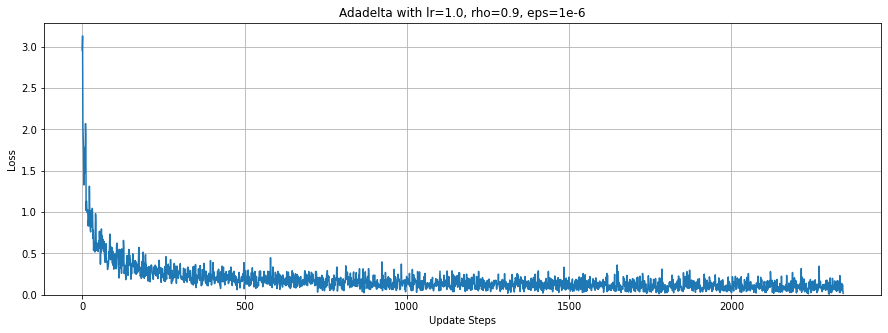

In [50]:
plot_loss(adadelta_loss, 'Adadelta with lr=1.0, rho=0.9, eps=1e-6')

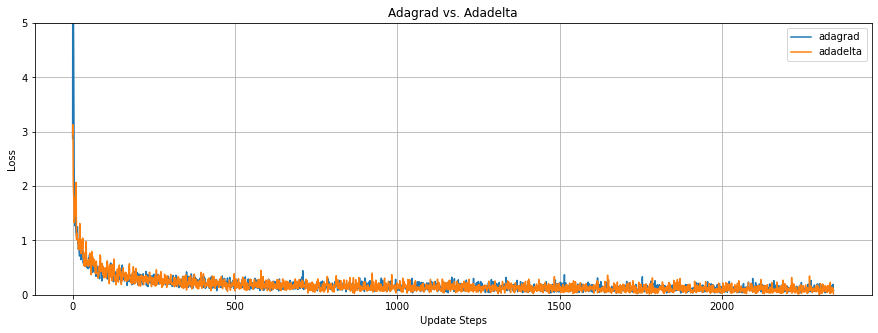

In [52]:
losses = [adagrad_loss, adadelta_loss]
labels = ['adagrad', 'adadelta']
plot_losses(losses, labels, 'Adagrad vs. Adadelta', ymax=5.0)

# Optimizer #5: RMSprop

In [ ]:
"""
Adadelta equation? The one that we said had the issue of the update units not matching the parameter units?
Turns out you can completely ignore the fact that these units don't match up and this gives you the RMSprop 
algorithm! RMSprop is commonly used in reinforcement learning and one hyperparameter that's tweaked a lot is 
the eps parameter.

In the link below there is a nice comparison of the implementation chosen by pytorch and tensorflow. Especially
they seem to use a different formulation for parameter epsion.
"""

In [55]:
class RMSprop:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [56]:
optimizer = RMSprop(model.parameters())
rmsprop_loss = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:25, 18.31it/s]



  1%|          | 4/469 [00:00<00:24, 18.60it/s]



  1%|▏         | 6/469 [00:00<00:25, 17.81it/s]



  2%|▏         | 8/469 [00:00<00:26, 17.48it/s]



  2%|▏         | 11/469 [00:00<00:23, 19.55it/s]



  3%|▎         | 13/469 [00:00<00:24, 18.88it/s]



  3%|▎         | 15/469 [00:00<00:23, 19.13it/s]



  4%|▎         | 17/469 [00:00<00:23, 19.03it/s]



  4%|▍         | 20/469 [00:01<00:22, 19.79it/s]



  5%|▍         | 22/469 [00:01<00:22, 19.75it/s]



  5%|▌         | 25/469 [00:01<00:22, 19.94it/s]



  6%|▌         | 27/469 [00:01<00:22, 19.94it/s]



  6%|▋         | 30/469 [00:01<00:21, 20.78it/s]



  7%|▋         | 33/469 [00:01<00:20, 20.95it/s]



  8%|▊         | 36/469 [00:01<00:20, 20.79it/s]



  8%|▊         | 39/469 [00:01<00:20, 20.64it/s]



  9%|▉         | 42/469 [00:02<00:20, 20.89it/s]



 10%|▉         | 45/469 [00:02<00:20, 20.89it/s]



 10%|█         | 48/4

 58%|█████▊    | 274/469 [00:12<00:08, 23.24it/s]



 59%|█████▉    | 277/469 [00:12<00:08, 22.81it/s]



 60%|█████▉    | 280/469 [00:12<00:08, 22.79it/s]



 60%|██████    | 283/469 [00:12<00:08, 22.32it/s]



 61%|██████    | 286/469 [00:12<00:08, 21.53it/s]



 62%|██████▏   | 289/469 [00:13<00:08, 21.03it/s]



 62%|██████▏   | 292/469 [00:13<00:08, 20.70it/s]



 63%|██████▎   | 295/469 [00:13<00:08, 20.68it/s]



 64%|██████▎   | 298/469 [00:13<00:08, 21.26it/s]



 64%|██████▍   | 301/469 [00:13<00:07, 21.45it/s]



 65%|██████▍   | 304/469 [00:13<00:07, 22.01it/s]



 65%|██████▌   | 307/469 [00:13<00:07, 22.20it/s]



 66%|██████▌   | 310/469 [00:13<00:07, 22.50it/s]



 67%|██████▋   | 313/469 [00:14<00:06, 22.99it/s]



 67%|██████▋   | 316/469 [00:14<00:06, 23.29it/s]



 68%|██████▊   | 319/469 [00:14<00:06, 23.43it/s]



 69%|██████▊   | 322/469 [00:14<00:06, 23.51it/s]



 69%|██████▉   | 325/469 [00:14<00:06, 22.95it/s]



 70%|██████▉   | 328/469 [00:14<00:06, 22.83it

 19%|█▊        | 87/469 [00:03<00:18, 20.32it/s]



 19%|█▉        | 90/469 [00:04<00:18, 20.23it/s]



 20%|█▉        | 93/469 [00:04<00:18, 20.67it/s]



 20%|██        | 96/469 [00:04<00:17, 21.44it/s]



 21%|██        | 99/469 [00:04<00:16, 22.22it/s]



 22%|██▏       | 102/469 [00:04<00:16, 22.60it/s]



 22%|██▏       | 105/469 [00:04<00:15, 22.80it/s]



 23%|██▎       | 108/469 [00:04<00:16, 22.30it/s]



 24%|██▎       | 111/469 [00:05<00:15, 22.49it/s]



 24%|██▍       | 114/469 [00:05<00:15, 22.98it/s]



 25%|██▍       | 117/469 [00:05<00:15, 23.27it/s]



 26%|██▌       | 120/469 [00:05<00:14, 23.40it/s]



 26%|██▌       | 123/469 [00:05<00:14, 23.29it/s]



 27%|██▋       | 126/469 [00:05<00:14, 23.13it/s]



 28%|██▊       | 129/469 [00:05<00:14, 23.25it/s]



 28%|██▊       | 132/469 [00:05<00:14, 22.73it/s]



 29%|██▉       | 135/469 [00:06<00:14, 22.89it/s]



 29%|██▉       | 138/469 [00:06<00:14, 23.13it/s]



 30%|███       | 141/469 [00:06<00:14, 23.31it/s]



 79%|███████▉  | 371/469 [00:16<00:04, 22.66it/s]



 80%|███████▉  | 374/469 [00:16<00:04, 23.06it/s]



 80%|████████  | 377/469 [00:17<00:03, 23.15it/s]



 81%|████████  | 380/469 [00:17<00:03, 23.39it/s]



 82%|████████▏ | 383/469 [00:17<00:03, 23.30it/s]



 82%|████████▏ | 386/469 [00:17<00:03, 22.65it/s]



 83%|████████▎ | 389/469 [00:17<00:03, 22.75it/s]



 84%|████████▎ | 392/469 [00:17<00:03, 23.06it/s]



 84%|████████▍ | 395/469 [00:17<00:03, 23.09it/s]



 85%|████████▍ | 398/469 [00:17<00:03, 23.38it/s]



 86%|████████▌ | 401/469 [00:18<00:02, 23.47it/s]



 86%|████████▌ | 404/469 [00:18<00:02, 23.55it/s]



 87%|████████▋ | 407/469 [00:18<00:02, 23.47it/s]



 87%|████████▋ | 410/469 [00:18<00:02, 23.00it/s]



 88%|████████▊ | 413/469 [00:18<00:02, 22.87it/s]



 89%|████████▊ | 416/469 [00:18<00:02, 23.01it/s]



 89%|████████▉ | 419/469 [00:18<00:02, 23.01it/s]



 90%|████████▉ | 422/469 [00:18<00:02, 23.08it/s]



 91%|█████████ | 425/469 [00:19<00:01, 23.09it

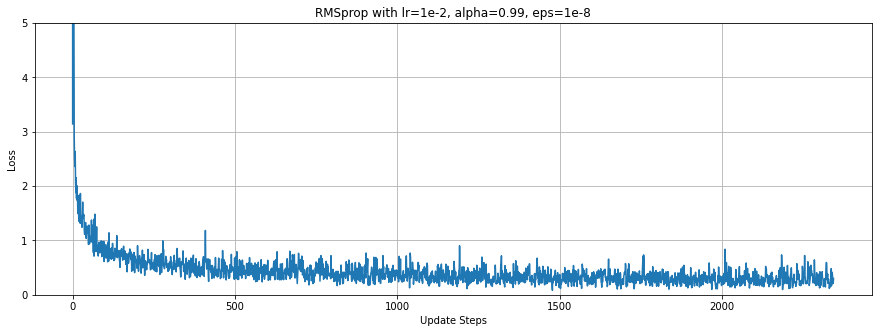

In [57]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8', ymax=5.0)

# Optimizer #6: Adam

In [ ]:
"""
RMSprop's idea of annealing the step size over time, whilst using an exponential moving average to avoid 
saturation, seemed to work out OK. What if we added momentum to it? That's how you get Adam.

Adam has an exponential moving average of the gradients, like the momentum term that can be added to SGD,
and an exponential moving average of squared gradients, like RMSprop and Adadelta.
"""

In [60]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            
            self.n_steps += 1
            
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            
            param.sub_(self.lr * avg_grad_corrected / std)

In [62]:
optimizer = Adam(model.parameters())
adam_loss = train(train_iterator, model, optimizer, criterion, device)





  0%|          | 0/469 [00:00<?, ?it/s]



  0%|          | 2/469 [00:00<00:25, 18.60it/s]



  1%|          | 5/469 [00:00<00:23, 20.15it/s]



  2%|▏         | 8/469 [00:00<00:22, 20.21it/s]



  2%|▏         | 11/469 [00:00<00:22, 20.74it/s]



  3%|▎         | 14/469 [00:00<00:21, 20.89it/s]



  4%|▎         | 17/469 [00:00<00:21, 21.17it/s]



  4%|▍         | 20/469 [00:00<00:21, 20.78it/s]



  5%|▍         | 23/469 [00:01<00:21, 20.62it/s]



  6%|▌         | 26/469 [00:01<00:21, 20.27it/s]



  6%|▌         | 29/469 [00:01<00:21, 20.12it/s]



  7%|▋         | 32/469 [00:01<00:22, 19.82it/s]



  7%|▋         | 34/469 [00:01<00:21, 19.77it/s]



  8%|▊         | 37/469 [00:01<00:21, 20.24it/s]



  9%|▊         | 40/469 [00:01<00:20, 20.85it/s]



  9%|▉         | 43/469 [00:02<00:20, 20.98it/s]



 10%|▉         | 46/469 [00:02<00:20, 20.71it/s]



 10%|█         | 49/469 [00:02<00:20, 20.52it/s]



 11%|█         | 52/469 [00:02<00:20, 20.28it/s]



 12%|█▏        | 55/

 42%|████▏     | 197/469 [00:09<00:12, 22.51it/s]



 43%|████▎     | 200/469 [00:09<00:11, 22.71it/s]



 43%|████▎     | 203/469 [00:09<00:11, 22.29it/s]



 44%|████▍     | 206/469 [00:09<00:11, 22.21it/s]



 45%|████▍     | 209/469 [00:09<00:11, 22.63it/s]



 45%|████▌     | 212/469 [00:09<00:11, 23.09it/s]



 46%|████▌     | 215/469 [00:09<00:10, 23.39it/s]



 46%|████▋     | 218/469 [00:09<00:10, 23.33it/s]



 47%|████▋     | 221/469 [00:10<00:10, 22.72it/s]



 48%|████▊     | 224/469 [00:10<00:11, 21.70it/s]



 48%|████▊     | 227/469 [00:10<00:11, 21.33it/s]



 49%|████▉     | 230/469 [00:10<00:11, 20.92it/s]



 50%|████▉     | 233/469 [00:10<00:11, 20.22it/s]



 50%|█████     | 236/469 [00:10<00:11, 19.67it/s]



 51%|█████     | 238/469 [00:10<00:11, 19.53it/s]



 51%|█████▏    | 241/469 [00:11<00:11, 20.22it/s]



 52%|█████▏    | 244/469 [00:11<00:10, 21.08it/s]



 53%|█████▎    | 247/469 [00:11<00:10, 21.42it/s]



 53%|█████▎    | 250/469 [00:11<00:10, 21.02it

 88%|████████▊ | 413/469 [00:19<00:02, 23.09it/s]



 89%|████████▊ | 416/469 [00:19<00:02, 23.16it/s]



 89%|████████▉ | 419/469 [00:20<00:02, 23.40it/s]



 90%|████████▉ | 422/469 [00:20<00:02, 22.95it/s]



 91%|█████████ | 425/469 [00:20<00:01, 22.85it/s]



 91%|█████████▏| 428/469 [00:20<00:01, 22.90it/s]



 92%|█████████▏| 431/469 [00:20<00:01, 22.99it/s]



 93%|█████████▎| 434/469 [00:20<00:01, 23.25it/s]



 93%|█████████▎| 437/469 [00:20<00:01, 23.32it/s]



 94%|█████████▍| 440/469 [00:21<00:01, 23.48it/s]



 94%|█████████▍| 443/469 [00:21<00:01, 23.32it/s]



 95%|█████████▌| 446/469 [00:21<00:01, 22.80it/s]



 96%|█████████▌| 449/469 [00:21<00:00, 22.53it/s]



 96%|█████████▋| 452/469 [00:21<00:00, 22.82it/s]



 97%|█████████▋| 455/469 [00:21<00:00, 22.78it/s]



 98%|█████████▊| 458/469 [00:21<00:00, 23.15it/s]



 98%|█████████▊| 461/469 [00:21<00:00, 23.39it/s]



 99%|█████████▉| 464/469 [00:22<00:00, 23.38it/s]



100%|██████████| 469/469 [00:22<00:00, 21.07it

 48%|████▊     | 226/469 [00:10<00:11, 21.09it/s]



 49%|████▉     | 229/469 [00:10<00:11, 21.48it/s]



 49%|████▉     | 232/469 [00:10<00:10, 22.04it/s]



 50%|█████     | 235/469 [00:11<00:10, 22.23it/s]



 51%|█████     | 238/469 [00:11<00:10, 21.33it/s]



 51%|█████▏    | 241/469 [00:11<00:10, 21.65it/s]



 52%|█████▏    | 244/469 [00:11<00:10, 22.23it/s]



 53%|█████▎    | 247/469 [00:11<00:09, 22.39it/s]



 53%|█████▎    | 250/469 [00:11<00:09, 22.40it/s]



 54%|█████▍    | 253/469 [00:11<00:09, 22.59it/s]



 55%|█████▍    | 256/469 [00:11<00:09, 22.80it/s]



 55%|█████▌    | 259/469 [00:12<00:09, 23.17it/s]



 56%|█████▌    | 262/469 [00:12<00:08, 23.39it/s]



 57%|█████▋    | 265/469 [00:12<00:08, 23.55it/s]



 57%|█████▋    | 268/469 [00:12<00:08, 23.34it/s]



 58%|█████▊    | 271/469 [00:12<00:08, 22.96it/s]



 58%|█████▊    | 274/469 [00:12<00:08, 21.94it/s]



 59%|█████▉    | 277/469 [00:12<00:08, 21.83it/s]



 60%|█████▉    | 280/469 [00:13<00:08, 21.59it

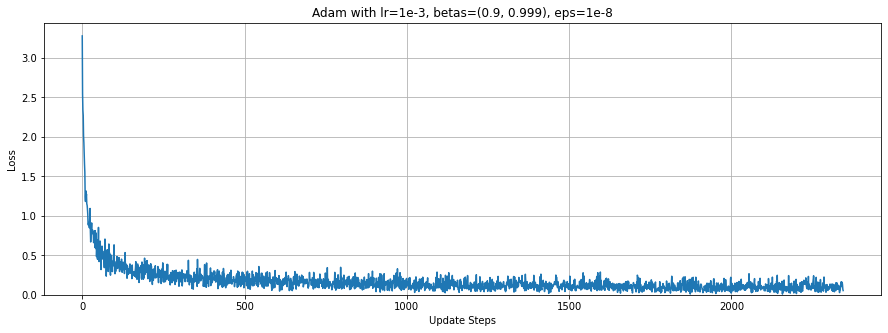

In [63]:
plot_loss(adam_loss, 'Adam with lr=1e-3, betas=(0.9, 0.999), eps=1e-8')

# References
<hr style="border:2px solid black"> </hr>


- https://github.com/bentrevett/a-tour-of-pytorch-optimizers/blob/main/a-tour-of-pytorch-optimizers.ipynb

